In [ ]:
import sys
import cv2
import numpy
import matplotlib
import skimage
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from random import randrange
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [ ]:
print('Python: {}'.format(sys.version))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))
print('Torch: {}'.format(torch.__version__))
print('Torchvision: {}'.format(torchvision.__version__))


Python: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
OpenCV: 4.1.2
NumPy: 1.18.5
Matplotlib: 3.2.2
Scikit-Image: 0.16.2
Torch: 1.7.0+cu101
Torchvision: 0.8.1+cu101


In [ ]:
from skimage.measure import compare_ssim as ssim
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
% cd /content/drive/'My Drive'/CVProject

/content/drive/My Drive/CVProject


In [ ]:
!ls /content/drive/'My Drive'/CVProject/SR_training_datasets/trainDataset

HR  LR


In [ ]:
data_files = glob.glob("/content/drive/My Drive/CVProject/SR_training_datasets/source/*")

In [ ]:
def psnr(target, ref):
  target_data = target.astype(float)
  ref_data = ref.astype(float)
  diff = ref_data - target_data
  diff = diff.flatten('C')
  rmse = math.sqrt(np.mean(diff ** 2.))
  return 20 * math.log10(255. / rmse)


def mse(target, ref):
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    return err

def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    return scores

I want to now create a directory to save all the images that have been processed using bicubic interpolation

In [ ]:
os.mkdir("/content/drive/My Drive/CVProject/SR_training_datasets/bicubic_images")

FileExistsError: ignored

In [ ]:
def preprocess(source_path,dest_path,factor):
  for file in os.listdir(source_path):
    img = cv2.imread(source_path+"/" + file)
    h, w,_ = img.shape
    img = cv2.resize(img,(0,0), fx=factor, fy=factor,interpolation = cv2.INTER_CUBIC)
    img = cv2.resize(img,(w,h),interpolation = cv2.INTER_CUBIC)

    cv2.imwrite("{}/{}".format(dest_path,file),img)
  print("done")


In [ ]:
preprocess("/content/drive/My Drive/CVProject/SR_training_datasets/source","/content/drive/My Drive/CVProject/SR_training_datasets/bicubic_images",0.25)

done


## Loading an Image with bicubic interpolation vs Reference picture

t8.png

Bicubic Interpolation
(190, 180, 3)


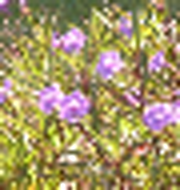



Reference


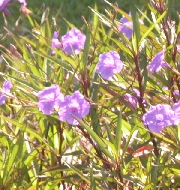

17.179016087828902


In [ ]:
image = os.listdir("/content/drive/My Drive/CVProject/SR_training_datasets/source")[0]
print(image + "\n")
print("Bicubic Interpolation")
bicubic = cv2.imread("/content/drive/My Drive/CVProject/SR_training_datasets/bicubic_images/{}".format(image))
print(bicubic.shape)
cv2_imshow(bicubic)
print("\n")
print("Reference")
ref = cv2.imread("/content/drive/My Drive/CVProject/SR_training_datasets/source/{}".format(image))
cv2_imshow(ref)

print(psnr(bicubic,ref))


In [ ]:
from PIL import Image 
from matplotlib.pyplot import imshow
import numpy as np

In [ ]:
len(os.listdir("/content/drive/My Drive/CVProject/SR_training_datasets/bicubic_images"))

91

In [ ]:
os.listdir("/content/drive/My Drive/CVProject/SR_training_datasets/bicubic_images")[0]

't8.png'

In [ ]:
# os.mkdir("/content/drive/My Drive/CVProject/SR_training_datasets/trainDataset")
os.mkdir("/content/drive/My Drive/CVProject/SR_training_datasets/trainDataset/LR")
os.mkdir("/content/drive/My Drive/CVProject/SR_training_datasets/trainDataset/HR")

In [ ]:
# def crop_images(source_path,dest_path):
#   for file in os.listdir(source_path):
#     hr = cv2.imread("{}/{}".format(source_path,file))
#     imgheight, imgwidth,_ = hr.shape
#     x1 = randrange(0,imgwidth - 33)
#     y1 = randrange(0,imgheight - 33)
#     high = hr[y1:y1+33,x1:x1+33]
#     cv2.waitKey(0)
#     # high = hr.crop((x1, y1, x1 + 33, y1 + 33))
#     h, w,_ = high.shape
#     img = cv2.resize(high,(0,0), fx=0.25, fy=0.25,interpolation = cv2.INTER_CUBIC)
#     img = cv2.resize(img,(w,h),interpolation = cv2.INTER_CUBIC)
#     cv2.imwrite("{}/HR/{}".format(dest_path,file),high)
#     cv2.imwrite("{}/LR/{}".format(dest_path,file),img)

def crop_images(source_path,dest_path):
  for file in os.listdir(source_path):
    print(file)
    hr = cv2.imread("{}/{}".format(source_path,file))
    height, width = hr.shape[:2]
    snippet = 1
    if not os.path.isdir("{}/HR/{}".format(dest_path,file)):
      os.mkdir("{}/HR/{}".format(dest_path,file))
    if not os.path.isdir("{}/LR/{}".format(dest_path,file)):
      os.mkdir("{}/LR/{}".format(dest_path,file))
    for y in range(0, height - 32, 14):
      for x in range(0, width - 32, 14):
        high = hr[y:y+33,x:x+33]
        cv2.waitKey(0)
        h, w = high.shape[:2]
        img = cv2.resize(high,(0,0), fx=4, fy=4,interpolation = cv2.INTER_CUBIC)
        img = cv2.resize(img,(w,h),interpolation = cv2.INTER_CUBIC)
        cv2.imwrite("{}/HR/{}/{}".format(dest_path,file,snippet),high)
        cv2.imwrite("{}/LR/{}/{}".format(dest_path,file,snippet),img)
        snippet+=1


In [ ]:
os.listdir("/content/drive/My Drive/CVProject/SR_training_datasets/source")

['t8.png',
 'tt26.png',
 'tt14.png',
 't54.png',
 't30.png',
 'tt22.png',
 't60.png',
 'tt27.png',
 't42.png',
 'tt8.png',
 't27.png',
 't29.png',
 't55.png',
 't14.png',
 't4.png',
 't19.png',
 'tt25.png',
 'tt20.png',
 'tt15.png',
 't35.png',
 't49.png',
 't40.png',
 'tt23.png',
 't22.png',
 't53.png',
 'tt17.png',
 'tt18.png',
 't5.png',
 't3.png',
 't37.png',
 'tt13.png',
 't18.png',
 't43.png',
 't16.png',
 't26.png',
 't62.png',
 't13.png',
 't11.png',
 't15.png',
 't51.png',
 't65.png',
 'tt4.png',
 't58.png',
 'tt7.png',
 't9.png',
 't31.png',
 't47.png',
 'tt2.png',
 't17.png',
 't56.png',
 't32.png',
 't38.png',
 'tt1.png',
 't23.png',
 't20.png',
 't63.png',
 'tt21.png',
 't48.png',
 't2.png',
 't64.png',
 't33.png',
 't1.png',
 't59.png',
 't36.png',
 'tt9.png',
 'tt24.png',
 't45.png',
 't12.png',
 'tt10.png',
 't7.png',
 'tt19.png',
 'tt16.png',
 't50.png',
 't34.png',
 'tt6.png',
 't61.png',
 't25.png',
 't46.png',
 'tt3.png',
 't52.png',
 't39.png',
 't44.png',
 't21.pn

(290, 411, 3)
133
0
(33, 33, 3)


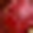

25.679863338785257


In [ ]:
hr = cv2.imread("/content/drive/My Drive/CVProject/SR_training_datasets/source/tt26.png")
imgheight, imgwidth,_ = hr.shape
print(hr.shape)
x1 = randrange(0,imgwidth - 33)
y1 = randrange(0,imgheight - 33)
print(x1)
print(y1)
crop_img = hr[y1:y1+33,x1:x1+33]
cv2.waitKey(0)
#print(crop_img)
h, w,_ = crop_img.shape
print(crop_img.shape)
img = cv2.resize(crop_img,(0,0), fx=0.25, fy=0.25,interpolation = cv2.INTER_CUBIC)
img = cv2.resize(img,(w,h),interpolation = cv2.INTER_CUBIC)
cv2_imshow(img)

print(psnr(img,crop_img))

In [ ]:
crop_images("/content/drive/My Drive/CVProject/SR_training_datasets/source","/content/drive/My Drive/CVProject/SR_training_datasets/trainDataset")

t8.png
tt26.png
tt14.png
t54.png
t30.png
tt22.png
t60.png
tt27.png
t42.png
tt8.png
t27.png
t29.png
t55.png
t14.png
t4.png
t19.png
tt25.png
tt20.png
tt15.png
t35.png
t49.png
t40.png
tt23.png
t22.png
t53.png
tt17.png
tt18.png
t5.png
t3.png
t37.png
tt13.png
t18.png
t43.png
t16.png
t26.png
t62.png
t13.png
t11.png
t15.png
t51.png
t65.png
tt4.png
t58.png
tt7.png
t9.png
t31.png
t47.png
tt2.png
t17.png
t56.png
t32.png
t38.png
tt1.png
t23.png
t20.png
t63.png
tt21.png
t48.png
t2.png
t64.png
t33.png
t1.png
t59.png
t36.png
tt9.png
tt24.png
t45.png
t12.png
tt10.png
t7.png
tt19.png
tt16.png
t50.png
t34.png
tt6.png
t61.png
t25.png
t46.png
tt3.png
t52.png
t39.png
t44.png
t21.png
t10.png
t28.png
t66.png
tt12.png
tt5.png
t6.png
t57.png
t24.png


In [ ]:
len(os.listdir("/content/drive/My Drive/CVProject/SR_training_datasets/trainDataset/LR"))

91